# Importing and Connection to the database

In [2]:
import pymongo
import pprint
from math import dist

In [3]:
client = pymongo.MongoClient('localhost', 27017)
db = client['demo']
restaurants = db['restaurants']

# Basic Queries

### Get the first record from the database

In [4]:
query = restaurants.find_one()
pprint.pprint(query)

{'_id': ObjectId('63f4280792e93c474289721a'),
 'address': {'building': '351',
             'coord': [-73.98513559999999, 40.7676919],
             'street': 'West   57 Street',
             'zipcode': '10019'},
 'borough': 'Manhattan',
 'cuisine': 'Irish',
 'grades': [{'date': datetime.datetime(2014, 9, 6, 0, 0),
             'grade': 'A',
             'score': 2},
            {'date': datetime.datetime(2013, 7, 22, 0, 0),
             'grade': 'A',
             'score': 11},
            {'date': datetime.datetime(2012, 7, 31, 0, 0),
             'grade': 'A',
             'score': 12},
            {'date': datetime.datetime(2011, 12, 29, 0, 0),
             'grade': 'A',
             'score': 12}],
 'name': 'Dj Reynolds Pub And Restaurant',
 'restaurant_id': '30191841'}


### Get the information for the restaurant called "Towne Cafe"

In [5]:
query = restaurants.find({"name": "Towne Cafe"})
for restaurant in query:
    pprint.pprint(restaurant)

{'_id': ObjectId('63f4280792e93c474289726a'),
 'address': {'building': '2602',
             'coord': [-73.95443709999999, 40.5877993],
             'street': 'East   15 Street',
             'zipcode': '11235'},
 'borough': 'Brooklyn',
 'cuisine': 'American',
 'grades': [{'date': datetime.datetime(2014, 5, 14, 0, 0),
             'grade': 'A',
             'score': 11},
            {'date': datetime.datetime(2013, 4, 27, 0, 0),
             'grade': 'A',
             'score': 9},
            {'date': datetime.datetime(2012, 11, 23, 0, 0),
             'grade': 'B',
             'score': 27},
            {'date': datetime.datetime(2012, 3, 14, 0, 0),
             'grade': 'B',
             'score': 17},
            {'date': datetime.datetime(2011, 7, 14, 0, 0),
             'grade': 'B',
             'score': 21}],
 'name': 'Towne Cafe',
 'restaurant_id': '40364681'}


### What Restaurants are on Church Street

In [6]:
query = restaurants.find({"address.street":"Church Street"}, {"name":1,"_id":0})
for i in range(10):
    pprint.pprint(query[i])

{'name': 'Downtown Deli'}
{'name': "Domino'S Pizza"}
{'name': "South'S"}
{'name': 'Macao  Restuarant And Bar'}
{'name': 'B Flat'}
{'name': 'La Colombe Torrefaction'}
{'name': "Saluggi'S"}
{'name': 'Westside Coffee Shop Restaurant'}
{'name': 'Dunkin Donuts'}
{'name': 'Starbucks Coffee'}


# Level 2 Queries

# Find number of restaurants in Brooklyn

In [7]:
query1 = restaurants.count_documents({"borough":"Brooklyn"})

pprint.pprint(query1)


6086


# Find number of Italian Restaurants in Bronx

In [8]:
query2 = restaurants.count_documents({"cuisine":"Italian", "borough":"Bronx"})

pprint.pprint(query2)

52


# Level 3 Queries

# How many Restaurants are in each Zipcode

In [9]:
query3 = restaurants.aggregate([
    {"$group": {"_id": "$address.zipcode","num": {"$sum": 1}}},
    {"$sort": {"num":-1}} 
])

query_list = list(query3)

for q in range(10):
    pprint.pprint(query_list[q])
    

{'_id': '10003', 'num': 686}
{'_id': '10019', 'num': 675}
{'_id': '10036', 'num': 611}
{'_id': '10001', 'num': 520}
{'_id': '10022', 'num': 485}
{'_id': '10013', 'num': 480}
{'_id': '10002', 'num': 471}
{'_id': '10011', 'num': 467}
{'_id': '10016', 'num': 433}
{'_id': '10014', 'num': 428}


# How many Restaurants per cuisine

In [10]:
query4 = restaurants.aggregate([
    {"$group": {"_id": "$cuisine","num": {"$sum": 1}}},
    {"$sort": {"num":-1}} 
])

query_list = list(query4)

for i in range(10):
    pprint.pprint(query_list[i])

{'_id': 'American', 'num': 6183}
{'_id': 'Chinese', 'num': 2418}
{'_id': 'Café/Coffee/Tea', 'num': 1214}
{'_id': 'Pizza', 'num': 1163}
{'_id': 'Italian', 'num': 1069}
{'_id': 'Other', 'num': 1011}
{'_id': 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
 'num': 850}
{'_id': 'Japanese', 'num': 760}
{'_id': 'Mexican', 'num': 754}
{'_id': 'Bakery', 'num': 691}


# Level 4 Queries

# Using Match Stage to Filter for boroughs with over 1,000 restaurants

In [11]:
query5 = restaurants.aggregate([
    {"$group": {"_id": "$borough","num": {"$sum": 1}}},
    {'$match': {'num' : {'$gte' : 1000}}},
    {"$sort": {"num":-1}} 
])

query_list = list(query5)

for q in query_list:
    pprint.pprint(q)


{'_id': 'Manhattan', 'num': 10259}
{'_id': 'Brooklyn', 'num': 6086}
{'_id': 'Queens', 'num': 5656}
{'_id': 'Bronx', 'num': 2338}


# Using Match to filter for Irish Restaurants in Manhattan

In [12]:
query6 = restaurants.aggregate([
    {'$match': {'cuisine' : {'$eq' : 'Irish'}, 'borough': {'$eq' : 'Manhattan'}}},
    {"$group": {"_id": "$cuisine", "num": {"$sum": 1}}},
    {"$sort": {"num":-1}} 
])

query_list = list(query6)

for q in query_list:
    pprint.pprint(q)


{'_id': 'Irish', 'num': 116}


# Level 5 Queries

# Finding 5 closest restaurants to empire state building
- Add field for distance from empire state
- Return 5 closest distances

In [70]:
empire_state_coord = [-73.9851304, 40.748817]

pipeline =[
  {
    '$addFields': {
      'distance': {
        '$sqrt': {
          '$add': [
            {
              '$pow': [
                {
                  '$subtract': [
                    {
                      '$arrayElemAt': [
                        '$address.coord', 0
                      ]
                    }, empire_state_coord[0]
                  ]
                }, 2
              ]
            }, {
              '$pow': [
                {
                  '$subtract': [
                    {
                      '$arrayElemAt': [
                        '$address.coord', 1
                      ]
                    }, empire_state_coord[1]
                  ]
                }, 2
              ]
            }
          ]
        }
      }
    }
  },
{'$project': {'_id' : 0, 'name': 1, 'distance': 1, 'address.coord': 1, 'cuisine': 1}},
{"$sort": {"distance":1}} 
]


Citation:
MongoDB. (2019, February 5). How to calculate distance between two geolocation points [Online forum post].
MongoDB Community Forums. 
https://www.mongodb.com/community/forums/t/how-to-calculate-distance-between-two-geolocation-points/173045/2

In [95]:
query7 = restaurants.aggregate(pipeline)

query_list7 = list(query7)

for i in range(20):
    pprint.pprint(query_list7[i])

{'address': {'coord': []},
 'cuisine': 'American',
 'distance': None,
 'name': "Fratelli'S Market Place"}
{'address': {'coord': []},
 'cuisine': 'American',
 'distance': None,
 'name': 'Eugene & Co'}
{'address': {'coord': [-73.98505639999999, 40.7492649]},
 'cuisine': 'Sandwiches',
 'distance': 0.0004539718163053264,
 'name': 'Subway'}
{'address': {'coord': [-73.98505639999999, 40.7492649]},
 'cuisine': 'American',
 'distance': 0.0004539718163053264,
 'name': 'The Stellan'}
{'address': {'coord': [-73.98468919999999, 40.7491101]},
 'cuisine': 'Sandwiches/Salads/Mixed Buffet',
 'distance': 0.0005296839151894624,
 'name': 'Potbelly Sandwich Shop'}
{'address': {'coord': [-73.9845235, 40.7494199]},
 'cuisine': 'American',
 'distance': 0.0008554624597293969,
 'name': 'Radio Star'}
{'address': {'coord': [-73.9859105, 40.7492349]},
 'cuisine': 'Other',
 'distance': 0.0008849838529577749,
 'name': "Auntie Anne'S"}
{'address': {'coord': [-73.9854099, 40.749687]},
 'cuisine': 'Pizza/Italian',
 'd

# Finding 5 Best Indian Restaurants in Manhattan

- Finding american restaurants in manhattan
- Adding Average score field
- Returning 5 best scores (lower score is better)

In [72]:
# Number of Indian Restaurants in Manhattan
query6 = restaurants.aggregate([
    {'$match': {'cuisine' : {'$eq' : 'Indian'}, 'borough': {'$eq' : 'Manhattan'}}},
    {"$group": {"_id": "$cuisine", "num": {"$sum": 1}}},
    {"$sort": {"num":-1}} 
])

query_list = list(query6)

for q in query_list:
    pprint.pprint(q)


{'_id': 'Indian', 'num': 152}


In [73]:
# adding average score fields for each restaurant
query6 = restaurants.aggregate([
    {'$match': {'cuisine': {'$eq': 'Indian'},'borough': {'$eq': 'Manhattan'}}},
    {'$project': {'_id': 0,'name': 1,'borough': 1, 'cuisine': 1,
                  'num_grades': {'$size': '$grades'},'total_score': {'$sum': '$grades.score'}}},
    {'$match': {'num_grades': {'$gt': 0}}},
    {'$addFields': {'average_score': {'$divide': ['$total_score', '$num_grades']}}},
    {'$sort': {'average_score': 1}}])

query_list = list(query6)

for i in range(5):
    pprint.pprint(query_list[i])


{'average_score': 2.5,
 'borough': 'Manhattan',
 'cuisine': 'Indian',
 'name': 'Diwan-E-Khaas',
 'num_grades': 4,
 'total_score': 10}
{'average_score': 3.0,
 'borough': 'Manhattan',
 'cuisine': 'Indian',
 'name': 'Bricklane Curry House',
 'num_grades': 1,
 'total_score': 3}
{'average_score': 4.0,
 'borough': 'Manhattan',
 'cuisine': 'Indian',
 'name': 'Soho Tiffin Junction',
 'num_grades': 1,
 'total_score': 4}
{'average_score': 4.75,
 'borough': 'Manhattan',
 'cuisine': 'Indian',
 'name': 'Diwan-E- Khaas',
 'num_grades': 4,
 'total_score': 19}
{'average_score': 5.75,
 'borough': 'Manhattan',
 'cuisine': 'Indian',
 'name': 'Taj Cafe',
 'num_grades': 4,
 'total_score': 23}


In [74]:
# Import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Convert query_list7 (a list of dictionaries) to a pandas dataframe
df = pd.DataFrame(query_list7)


In [75]:
# filter out all rows where distance is None
df = df[df['distance'].notna()]
# Create a new column called x-coord that contains the first element of the coord list
df['x-coord'] = df['address'].apply(lambda x: x['coord'][0])
# Create a new column called y-coord that contains the second element of the coord list
df['y-coord'] = df['address'].apply(lambda x: x['coord'][1])

In [76]:
df

,address,cuisine,name,distance,x-coord,y-coord
2,"{'coord': [-73.98505639999999, 40.7492649]}",Sandwiches,Subway,0.000454,-73.985056,40.749265
3,"{'coord': [-73.98505639999999, 40.7492649]}",American,The Stellan,0.000454,-73.985056,40.749265
4,"{'coord': [-73.98468919999999, 40.7491101]}",Sandwiches/Salads/Mixed Buffet,Potbelly Sandwich Shop,0.000530,-73.984689,40.749110
5,"{'coord': [-73.9845235, 40.7494199]}",American,Radio Star,0.000855,-73.984523,40.749420
6,"{'coord': [-73.9859105, 40.7492349]}",Other,Auntie Anne'S,0.000885,-73.985911,40.749235
...,...,...,...,...,...,...
25354,"{'coord': [100.6177619, 13.7085011]}",American,Lke Catering,176.684319,100.617762,13.708501
25355,"{'coord': [100.6294417, 13.7440888]}",Mexican,The Taco Truck,176.690419,100.629442,13.744089
25356,"{'coord': [104.9179596, 11.5415182]}",Café/Coffee/Tea,Starbucks Coffee,181.271570,104.917960,11.541518
25357,"{'coord': [104.9179596, 11.5415182]}",Continental,Todd English Bonfire,181.271570,104.917960,11.541518


In [77]:
# Append the Empire State Building coordinates to the dataframe
df = df.append({'address': 'None', 'name': 'Empire State Building', 'distance': 0, 'x-coord': empire_state_coord[0], 'y-coord': empire_state_coord[1], 'cuisine': 'none'}, ignore_index=True)

/var/folders/h7/zb9vsqrj4dv9gjlsgd_0p70h0000gn/T/ipykernel_6425/3906415687.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'address': 'None', 'name': 'Empire State Building', 'distance': 0, 'x-coord': empire_state_coord[0], 'y-coord': empire_state_coord[1], 'cuisine': 'none'}, ignore_index=True)


In [78]:
# Create a new column called relative x_coord that subtracts the x-coord of the Empire State Building from the x-coord of each restaurant
df['relative x_coord'] = df['x-coord'] - empire_state_coord[0]
# Create a new column called relative y_coord that subtracts the y-coord of the Empire State Building from the y-coord of each restaurant
df['relative y_coord'] = df['y-coord'] - empire_state_coord[1]

In [106]:
import numpy as np

# Rename all columns titled 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)' to 'Latin'
df['cuisine'] = df['cuisine'].apply(lambda x: 'Latin' if x == 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)' else x)

# Get the 10 most common cuisines
top_10_cuisines = df['cuisine'].value_counts().head(10).index.tolist()
print(top_10_cuisines)

# Create a dictionary that maps cuisine type to a color
cuisine_color = {'American': 'red', 'Chinese': 'blue', 'Café/Coffee/Tea': 'brown', 'Italian': 'green', 'Pizza': 'green', 'Pizza/Italian': 'green', 'Mexican': 'yellow', 'Latin': 'yellow', 'Other': 'black'}

# Create a new column that maps cuisine type to a color, if it is in the cuisine_color dictionary map it to the color, otherwise map it to black
df['color'] = df['cuisine'].apply(lambda x: cuisine_color[x] if x in cuisine_color else 'black')


['American', 'Chinese', 'Café/Coffee/Tea', 'Pizza', 'Italian', 'Other', 'Latin', 'Japanese', 'Mexican', 'Bakery']


,address,cuisine,name,distance,x-coord,y-coord,relative x_coord,relative y_coord,color
0,"{'coord': [-73.98505639999999, 40.7492649]}",Sandwiches,Subway,0.000454,-73.985056,40.749265,0.000074,0.000448,black
1,"{'coord': [-73.98505639999999, 40.7492649]}",American,The Stellan,0.000454,-73.985056,40.749265,0.000074,0.000448,red
2,"{'coord': [-73.98468919999999, 40.7491101]}",Sandwiches/Salads/Mixed Buffet,Potbelly Sandwich Shop,0.000530,-73.984689,40.749110,0.000441,0.000293,black
3,"{'coord': [-73.9845235, 40.7494199]}",American,Radio Star,0.000855,-73.984523,40.749420,0.000607,0.000603,red
4,"{'coord': [-73.9859105, 40.7492349]}",Other,Auntie Anne'S,0.000885,-73.985911,40.749235,-0.000780,0.000418,black
...,...,...,...,...,...,...,...,...,...
25353,"{'coord': [100.6294417, 13.7440888]}",Mexican,The Taco Truck,176.690419,100.629442,13.744089,174.614572,-27.004728,yellow
25354,"{'coord': [104.9179596, 11.5415182]}",Café/Coffee/Tea,Starbucks Coffee,181.271570,104.917960,11.541518,178.903090,-29.207299,brown
25355,"{'coord': [104.9179596, 11.5415182]}",Continental,Todd English Bonfire,181.271570,104.917960,11.541518,178.903090,-29.207299,black
25356,"{'coord': [153.1628795, -28.0168595]}",Steak,Sammy'S Steakhouse,237.328752,153.162880,-28.016859,227.148010,-68.765676,black


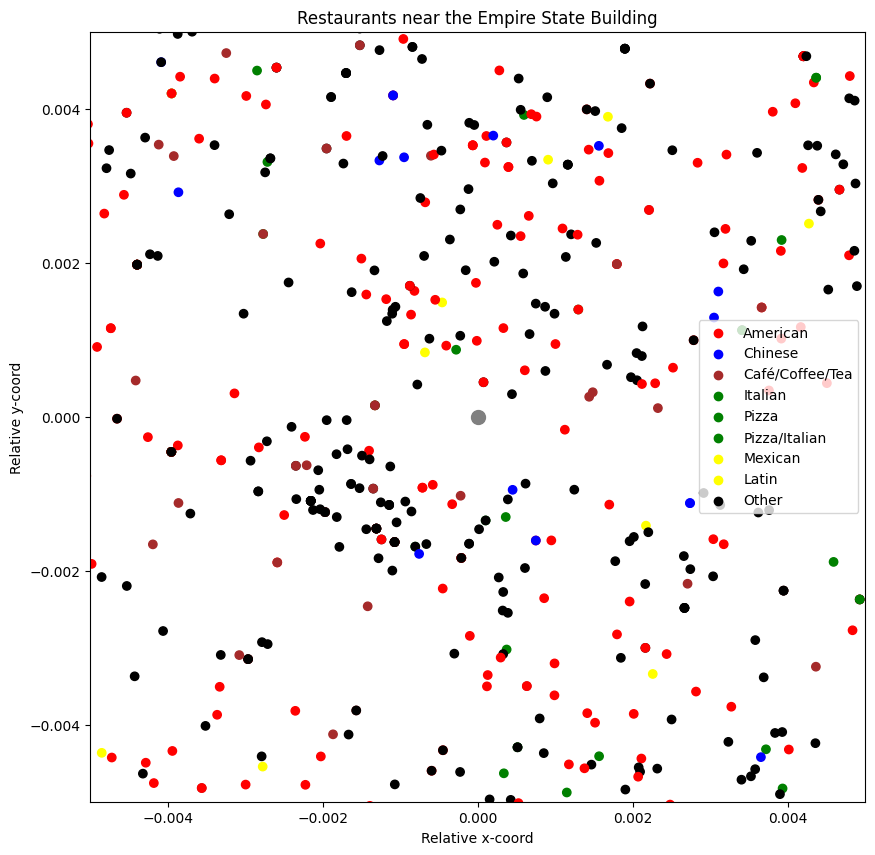

In [108]:
# Create a scatter plot of all the restaurants where the x-axis is the relative x-coord and the y-axis is the relative y-coord, and the color is the cuisine
plt.scatter(df['relative x_coord'], df['relative y_coord'], color=df['color'])
# Add a label to the x-axis
plt.xlabel('Relative x-coord')
# Add a label to the y-axis
plt.ylabel('Relative y-coord')
# Add a title
plt.title('Restaurants near the Empire State Building')
# Display the plot
plt.gcf().set_size_inches(10, 10)
# Draw an X at the Empire State Building
plt.scatter(0, 0, marker='o', color='grey', s=100)
# Set x and y limits at -200, 200
# create a legend
plt.legend(handles=[plt.scatter([],[], color=color, label=cuisine) for cuisine, color in cuisine_color.items()])
plt.xlim(-0.005, 0.005)
plt.ylim(-0.005, 0.005)
plt.show()